In [2]:
options(warn=-1)

suppressMessages(library(ArchR))
suppressMessages(library(Seurat))
suppressMessages(library(Signac))
suppressMessages(library(harmony))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(harmony))
suppressMessages(library(Nebulosa))
suppressMessages(library(ggpubr))
suppressMessages(library(Ipaper))
suppressMessages(library(phateR))
suppressMessages(library(parallel))
suppressMessages(library(ggrepel))
suppressMessages(library(circlize))

In [3]:
set.seed(42)
getwd()

addArchRThreads(threads = parallel::detectCores() - 2)
addArchRGenome("hg38")

[1] "/data/scATA/SingleCellOpenChromatin/local/VisiumHeartRevision/IntegrativeAnalysis/Fibroblast/code"

Setting default number of Parallel threads to 126.

Setting default genome to Hg38.



In [4]:
## subset atac project
proj <- loadArchRProject("../data/snATAC_SCARA5_Myofib", showLogo = FALSE)

Successfully loaded ArchRProject!



In [6]:
## we first plot the activity and expression of the selected TFs
df_tf <- read.csv("../data/snATAC_SCARA5_Myofib/sel_tf_by_expression.csv", row.names = 1)

In [8]:
## obtain tf activity along the trajectory
trajMM  <- getTrajectory(ArchRProj = proj,
                         name = "SCARA5_Myofib_dm",
                         useMatrix = "MotifMatrix",
                         log2Norm = FALSE,
                         scaleTo = NULL,
                        smoothWindow = 11)

trajMM <- trajMM[!grepl("deviations", rownames(trajMM)), ]

matMM <- plotTrajectoryHeatmap(trajMM, 
                            varCutOff = 0,
                            pal = paletteContinuous(set = "solarExtra"),
                            limits = c(-2, 2),
                              returnMatrix = TRUE)

df_motif_activity <- as.data.frame(matMM[df_tf$name1, ]) 
colnames(df_motif_activity) <- 1:100
df_motif_activity$tf <- rownames(df_motif_activity)

df_motif_activity2 <- tidyr::pivot_longer(df_motif_activity, -tf, names_to = "pseudotime", values_to = "tf_activity")

df_motif_activity2$pseudotime <- as.numeric(df_motif_activity2$pseudotime)
df_motif_activity2$tf <- stringr::str_split_fixed(df_motif_activity2$tf, ":", 2)[, 2]
df_motif_activity2$tf <- stringr::str_split_fixed(df_motif_activity2$tf, "_", 2)[, 1]

head(df_motif_activity2)

Creating Trajectory Group Matrix..

Smoothing...

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-21ddc864b70148-Date-2022-02-02_Time-17-05-45.log
If there is an issue, please report to github with logFile!

useSeqnames is NULL or greater than 1 with a Sparse.Assays.Matrix trajectory input.

2022-02-02 17:05:45 : 

force=FALSE thus continuing with subsetting useSeqnames = z

2022-02-02 17:05:45 : 

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-21ddc864b70148-Date-2022-02-02_Time-17-05-45.log



tf,pseudotime,tf_activity
<chr>,<dbl>,<dbl>
RELA,1,-1.611532
RELA,2,-1.611532
RELA,3,-1.611532
RELA,4,-1.611532
RELA,5,-1.611532
RELA,6,-1.611532


`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



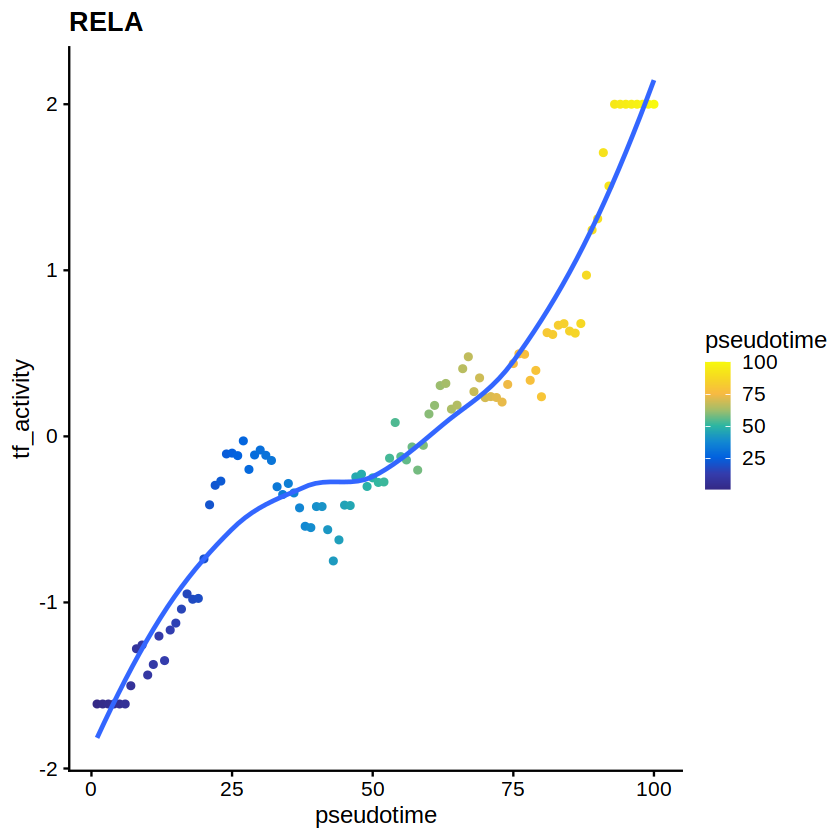

In [12]:
if(!dir.exists("../data/snATAC_SCARA5_Myofib/VisGRN/TF_Activity")){
    dir.create("../data/snATAC_SCARA5_Myofib/VisGRN/TF_Activity", recursive = TRUE)
}

for(name1 in unique(df_motif_activity2$tf)){
#for(name1 in c("RELA")){
    df_plot <- subset(df_motif_activity2, tf == name1)

    p <- ggplot(df_plot, aes(x = pseudotime, y = tf_activity)) +
        geom_point(aes(color = pseudotime)) + 
        scale_color_gradientn(colours = ArchR::paletteContinuous(set = "blueYellow")) +
     geom_smooth(method = "loess",se = FALSE) +
    theme_cowplot() + ggtitle(name1)
    
    print(p)
    
    ggsave(glue::glue("../data/snATAC_SCARA5_Myofib/VisGRN/TF_Activity/{name1}.pdf"),
          plot = p, height = 4, width = 5)

}

In [ ]:
trajGEX <- getTrajectory(ArchRProj = proj,
                         name = "SCARA5_Myofib_dm",
                         useMatrix = "GeneExpressionMatrix",
                         log2Norm = TRUE,
                        smoothWindow = 11)

trajGEX <- trajGEX[df_tf$name2, ]

gene_expression <- plotTrajectoryHeatmap(trajGEX,
                        varCutOff = 0,
                        pal = paletteContinuous(set = "horizonExtra"),
                        limits = c(-2, 2),
                                         returnMatrix = TRUE)

df_gene_expression <- as.data.frame(gene_expression) 
colnames(df_gene_expression) <- 1:100
df_gene_expression$tf <- rownames(df_gene_expression)

df_gene_expression2 <- tidyr::pivot_longer(df_gene_expression, -tf, names_to = "pseudotime", values_to = "tf_expression")

df_gene_expression2$pseudotime <- as.numeric(df_gene_expression2$pseudotime)
df_gene_expression2$tf <- stringr::str_split_fixed(df_gene_expression2$tf, ":", 2)[, 2]

if(!dir.exists("../data/snATAC_SCARA5_Myofib/VisGRN/TF_Expression")){
    dir.create("../data/snATAC_SCARA5_Myofib/VisGRN/TF_Expression", recursive = TRUE)
}

for(name1 in unique(df_gene_expression2$tf)){
    df_plot <- subset(df_gene_expression2, tf == name1)

    p <- ggplot(df_plot, aes(x = pseudotime, y = tf_expression)) +
        geom_point(aes(color = pseudotime)) + 
        scale_color_gradientn(colours = ArchR::paletteContinuous(set = "blueYellow")) +
     geom_smooth(method = "loess",se = FALSE) +
    theme_cowplot() + ggtitle(name1)
    
    
    ggsave(glue::glue("../data/snATAC_SCARA5_Myofib/VisGRN/TF_Expression/{name1}.pdf"),
          plot = p, height = 4, width = 5)

}

In [13]:
df_tf_gene <- read.csv("../data/snATAC_SCARA5_Myofib/gene_regulatory_network.csv")

df_tf_gene$tf <- stringr::str_split_fixed(df_tf_gene$tf, ":", 2)[, 2]

head(df_tf_gene)
nrow(df_tf_gene)

,tf,gene,correlation
,<chr>,<chr>,<dbl>
1,,PCOLCE2,0.9462578
2,,PCOLCE2,0.9476462
3,,PCOLCE2,0.9405444
4,,PCOLCE2,0.9121518
5,,PCOLCE2,0.7645778
6,,PCOLCE2,0.8967850


[1] 7992

In [18]:
trajGEX <- getTrajectory(ArchRProj = proj,
                         name = "SCARA5_Myofib_dm",
                         useMatrix = "GeneExpressionMatrix",
                         log2Norm = TRUE,
                        smoothWindow = 11)

gene_expression <- plotTrajectoryHeatmap(trajGEX,
                                         varCutOff = 0.2,
                                         limits = c(-2, 2),
                                         returnMatrix = TRUE)

rownames(gene_expression) <- stringr::str_split_fixed(rownames(gene_expression), ":", 2)[, 2]

df_gene_expression <- as.data.frame(gene_expression) 
colnames(df_gene_expression) <- 1:100
df_gene_expression$gene <- rownames(df_gene_expression)
df_gene_expression2 <- tidyr::pivot_longer(df_gene_expression, -gene, 
                                           names_to = "pseudotime", values_to = "gene_expression")
df_gene_expression2$pseudotime <- as.numeric(df_gene_expression2$pseudotime)

Creating Trajectory Group Matrix..

Smoothing...

ArchR logging to : ArchRLogs/ArchR-plotTrajectoryHeatmap-21ddc854d4ed79-Date-2022-02-02_Time-17-10-39.log
If there is an issue, please report to github with logFile!

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotTrajectoryHeatmap-21ddc854d4ed79-Date-2022-02-02_Time-17-10-39.log



`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



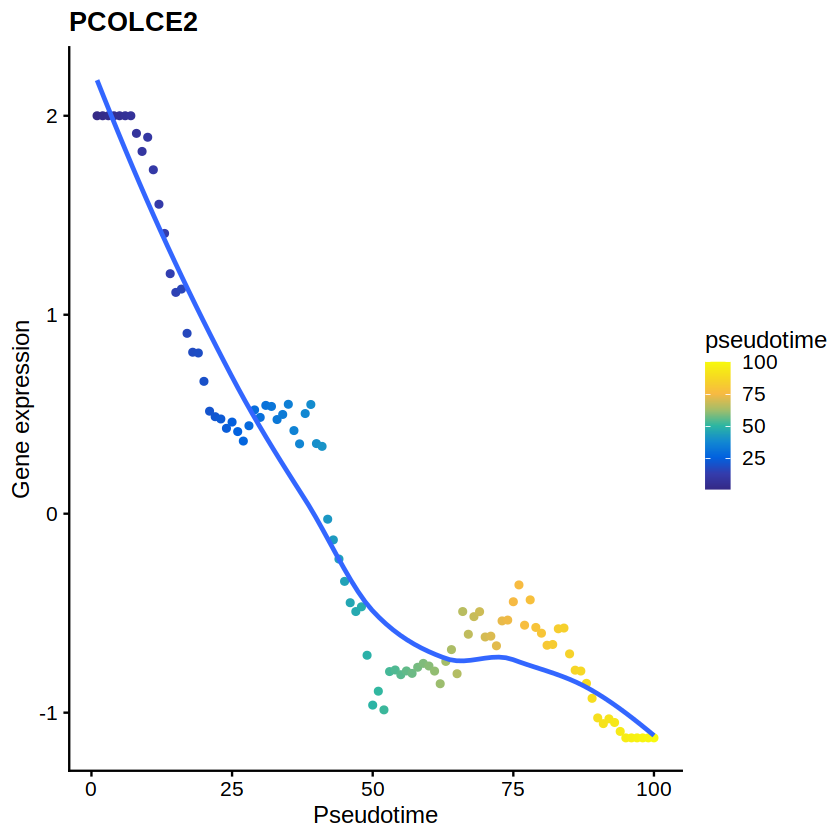

In [20]:
if(!dir.exists(glue::glue("../data/snATAC_SCARA5_Myofib/VisGRN/TF_Target_Expression"))){
        dir.create(glue::glue("../data/snATAC_SCARA5_Myofib/VisGRN/TF_Target_Expression"), 
                   recursive = TRUE)
    }

for(name1 in unique(df_tf_gene$gene)){
#for(name1 in unique(df_tf_gene$gene)[1:1]){
        df_plot <- subset(df_gene_expression2, gene == name1)

        p <- ggplot(df_plot, aes(x = pseudotime, y = gene_expression)) +
            geom_point(aes(color = pseudotime)) + 
        xlab("Pseudotime") + ylab("Gene expression") +
            scale_color_gradientn(colours = ArchR::paletteContinuous(set = "blueYellow")) +
         geom_smooth(method = "loess",se = FALSE) +
        theme_cowplot() + ggtitle(name1)
    
        ggsave(glue::glue("../data/snATAC_SCARA5_Myofib/VisGRN/TF_Target_Expression/{name1}.pdf"),
              plot = p, height = 4, width = 5)

    }